In [1]:
import sys
sys.path.append('..')
import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase
from itertools import groupby


from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
import networkx as nx

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

In [2]:
lrd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191023/lrd_d6z1_rel3_Karen/decomposition.tsv'
monomers_fn = "/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa"

lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [3]:
monomer_strings = {r_id: record.string for r_id, record in lrd_report.records.items()}
len(monomer_strings)

471

In [4]:
def filter_strings(monomer_strings, max_gap=0.05):
    filtered_strings = {}
    for r_id, string in monomer_strings.items():
        ngaps = Counter(string)['=']
        if ngaps / len(string) <= max_gap:
            filtered_strings[r_id] = string
    return filtered_strings

In [5]:
monomer_strings = filter_strings(monomer_strings)
len(monomer_strings)

408

In [116]:
def get_frequent_kmers(strings, k, min_mult=5):
    all_kmers = Counter()
    read_kmer_locations = defaultdict(list)
    for r_id, string in strings.items():
        for i in range(len(string)-k+1):
            kmer = string[i:i+k]
            if '=' not in kmer:
                all_kmers[kmer] += 1
                read_kmer_locations[kmer].append((r_id, i))
                
    frequent_kmers = {kmer: cnt for kmer, cnt in all_kmers.items()
                      if cnt >= min_mult}
    frequent_kmers_read_pos = {kmer: read_kmer_locations[kmer] for kmer in frequent_kmers}
    return frequent_kmers, frequent_kmers_read_pos


In [107]:
class DeBruijnGraph:
    def __init__(self, k, max_uniq_cov=30):
        self.graph = nx.DiGraph()
        self.k = k
        self.node_mapping = {}
        self.max_uniq_cov = max_uniq_cov

    def add_kmer(self, kmer, coverage=1):
        prefix, suffix = kmer[:-1], kmer[1:]
        
        if prefix in self.node_mapping:
            prefix_node_ind = self.node_mapping[prefix]
        else:
            prefix_node_ind = len(self.node_mapping)
            self.node_mapping[prefix] = prefix_node_ind
        
        if suffix in self.node_mapping:
            suffix_node_ind = self.node_mapping[suffix]
        else:
            suffix_node_ind = len(self.node_mapping)
            self.node_mapping[suffix] = suffix_node_ind
        
        # self.graph.add_edge(prefix, suffix,
        self.graph.add_edge(prefix_node_ind, suffix_node_ind,
                            edge_kmer=kmer,
                            length=self.k,
                            coverages=[coverage],
                            label=f'len={self.k}\ncov={coverage}',
                            color='black' if coverage < self.max_uniq_cov else 'red')

    def add_kmers(self, kmers, coverage=None):
        for kmer in kmers:
            if coverage is None:
                self.add_kmer(kmer)
            else:
                self.add_kmer(kmer, coverage=coverage[kmer])
                
    def index_edges(self, min_k=2):
        all_index = {}
        for k in range(min_k, self.k+1):
            index = defaultdict(list)
            for e_ind, edge in enumerate(self.graph.edges()):
                edge_seq = self.graph.get_edge_data(*edge)['edge_kmer']
                for i in range(len(edge_seq)-k+1):
                    kmer = edge_seq[i:i+k]
                    index[kmer].append((e_ind, i))
            index_unique = {kmer: pos[0]
                            for kmer, pos in index.items()
                            if len(pos) == 1}
            all_index[k] = index_unique
        return all_index
            
            
    def collapse_nonbranching_paths(self):
        def node_on_nonbranching_path(graph, node):
            return nx.number_of_nodes(graph) > 1 \
                and graph.in_degree(node) == 1 \
                and graph.out_degree(node) == 1

        for node in list(self.graph.nodes()):
            if node_on_nonbranching_path(self.graph, node):
                in_edge = list(self.graph.in_edges(node))[0]
                out_edge = list(self.graph.out_edges(node))[0]
                # in_edge_color = self.graph.edges[in_edge]['color']
                # out_edge_color = self.graph.edges[out_edge]['color']
                in_edge_kmer = self.graph.edges[in_edge]['edge_kmer']
                out_edge_kmer = self.graph.edges[out_edge]['edge_kmer']
                in_edge_cov = self.graph.edges[in_edge]['coverages']
                out_edge_cov = self.graph.edges[out_edge]['coverages']

                in_node = in_edge[0]
                out_node = out_edge[1]

                new_kmer = in_edge_kmer + \
                    out_edge_kmer[-(len(out_edge_kmer)-self.k+1):]
                new_coverages = in_edge_cov + out_edge_cov
                new_coverages.sort()
                new_edge_len = self.k+len(new_coverages)-1
                new_edge_med_cov = np.median(new_coverages)
                self.graph.add_edge(in_node, out_node,
                                    edge_kmer=new_kmer,
                                    coverages=new_coverages,
                                    length=new_edge_len,
                                    label=f'len={new_edge_len}\ncov={new_edge_med_cov}',
                                    color='black' if new_edge_med_cov < self.max_uniq_cov else 'red')
                self.graph.remove_node(node)

    def get_contigs(self):
        self.collapse_nonbranching_paths()
        contigs, coverages = [], []
        for edge in self.graph.edges():
            contigs.append(self.graph.get_edge_data(*edge)['edge_kmer'])
            coverages.append(np.median(self.graph.get_edge_data(*edge)['coverages']))
        return contigs, coverages
    
    def get_path(self, list_edges):
        db_edges = list(self.graph.edges())
        path = '' 
        path += self.graph.get_edge_data(*db_edges[list_edges[0]])['edge_kmer']
        for edge in list_edges[1:]:
            new_edge_seq = self.graph.get_edge_data(*db_edges[edge])['edge_kmer']
            # print(len(path[-(self.k-1):]), path[-(self.k-1):])
            # print(len(new_edge_seq[:self.k-1]), new_edge_seq[:self.k-1])
            assert path[-(self.k-1):] == new_edge_seq[:self.k-1]
            path += new_edge_seq[self.k-1:]
        # path = ''.join(path)
        return path
    
    # def get_valid_paths(self):
    #     def get_valid_paths_from_edge():


In [170]:
def iterative_graph(monomer_strings, min_k, max_k, min_mult=5, step=1, starting_graph=None):
    dbs, all_contigs = {}, {}
    input_strings = monomer_strings.copy()
    
    if starting_graph is not None:
        contigs, coverages = starting_graph.get_contigs()
        for i in range(len(contigs)):
            for j in range(min_mult):
                input_strings[f'contig_k{min_k}_i{i}_j{j}'] = contigs[i]

    for k in range(min_k, max_k+1, step):
        print(f'k={k}')
        # print(len(input_strings))
        frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(input_strings, k=k, min_mult=min_mult)
        # print(len(frequent_kmers))
        db = DeBruijnGraph(k=k)
        db.add_kmers(frequent_kmers, coverage=frequent_kmers)

        # lens = sorted((len(contig), coverage) for contig, coverage in zip(contigs, coverages))[::-1]
        # long_edges = [x for x in lens if x[1] >= 50]
        if nx.number_weakly_connected_components(db.graph) > 1:
            break
        db.collapse_nonbranching_paths()
        dbs[k] = db

        contigs, coverages = db.get_contigs()
        all_contigs[k] = contigs

        input_strings = monomer_strings.copy()
        # print(len(input_strings))
        for i in range(len(contigs)):
            for j in range(min_mult):
                input_strings[f'contig_k{k}_i{i}_j{j}'] = contigs[i]
        # print(len(input_strings))
    
    return all_contigs, dbs

In [151]:
min_k, max_k = 70, 300
contigs, dbs = iterative_graph(monomer_strings, min_k=min_k, max_k=max_k)
db = dbs[max_k]

k=70
408
1240
408
868
k=71
868
1270
408
878
k=72
878
1301
408
888
k=73
888
1332
408
903
k=74
903
1363
408
898
k=75
898
1394
408
903
k=76
903
1424
408
898
k=77
898
1455
408
913
k=78
913
1486
408
903
k=79
903
1517
408
893
k=80
893
1552
408
968
k=81
968
1587
408
968
k=82
968
1623
408
943
k=83
943
1665
408
1053
k=84
1053
1707
408
1048
k=85
1048
1749
408
1028
k=86
1028
1794
408
1093
k=87
1093
1839
408
1073
k=88
1073
1882
408
1063
k=89
1063
1926
408
1078
k=90
1078
1971
408
1093
k=91
1093
2016
408
1098
k=92
1098
2062
408
1118
k=93
1118
2108
408
1113
k=94
1113
2154
408
1098
k=95
1098
2203
408
1168
k=96
1168
2252
408
1163
k=97
1163
2301
408
1118
k=98
1118
2358
408
1278
k=99
1278
2415
408
1278
k=100
1278
2472
408
1238
k=101
1238
2538
408
1413
k=102
1413
2604
408
1413
k=103
1413
2670
408
1383
k=104
1383
2741
408
1483
k=105
1483
2812
408
1473
k=106
1473
2883
408
1478
k=107
1478
2955
408
1493
k=108
1493
3028
408
1518
k=109
1518
3101
408
1503
k=110
1503
3174
408
1528
k=111
1528
3247
408
1518
k=112
1

In [171]:
contigs, dbs = iterative_graph(monomer_strings, min_k=301, max_k=1000, starting_graph=dbs[max_k])


k=301
k=302
k=303
k=304
k=305
k=306
k=307
k=308
k=309
k=310
k=311
k=312
k=313
k=314
k=315
k=316
k=317
k=318
k=319
k=320


In [176]:
db = dbs[max(dbs.keys())]
assert nx.number_weakly_connected_components(db.graph) == 1

In [177]:
contigs, coverages = db.get_contigs()

In [178]:
np.median(coverages)

18.0

In [179]:
nx.drawing.nx_pydot.write_dot(db.graph, 'db.dot')

In [180]:
#nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(db.graph)

#nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
#                             password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

In [181]:
def map_reads(monomer_strings, db, db_index=None):
    if db_index is None:
        db_index = db.index_edges()
    mapping = {}
    db_edges = list(db.graph.edges())
    for r_id, string in monomer_strings.items():
        split_strings = list(filter(lambda string: len(string), string.split('=')))
        split_lens = [0] + [len(split_string) for split_string in split_strings]
        cum_split_lens = np.cumsum(split_lens)
        read_coords = []
        for split_ind, split_string in enumerate(split_strings):
            for i in range(len(split_string)-db.k+1):
                kmer = split_string[i:i+db.k]
                if kmer in db_index[len(kmer)]:
                    read_coords.append(db_index[len(kmer)][kmer])
        
        path = [x[0] for x in read_coords]
        path = [x[0] for x in groupby(path)]
        
        valid_path = True
        for e1, e2 in zip(path[:-1], path[1:]):
            if db_edges[e1][1] != db_edges[e2][0]:
                valid_path = False
                break
        if len(read_coords):
            mapping[r_id] = (read_coords[0], read_coords[-1], valid_path, path)
        else:
            mapping[r_id] = None
    return mapping

In [182]:
mapping = map_reads(monomer_strings, db)

In [183]:
print(np.mean([read_mapping is not None for read_mapping in mapping.values()]))
print(np.mean([read_mapping[2] for read_mapping in mapping.values() \
               if read_mapping is not None]))

for r_id, read_mapping in mapping.items():
    if read_mapping is not None and read_mapping[2]:
        print(r_id, len(monomer_strings[r_id]), len(monomer_strings[r_id]) * 171,
              len(db.get_path(read_mapping[-1])), read_mapping)

0.911764705882
0.873655913978
00739941-c14c-40bd-9fad-fabff753795b 798 136458 1292 ((4, 9), (4, 372), True, [4])
0352811e-b17c-4fc1-a73f-99757d30745c 623 106533 542 ((42, 94), (42, 107), True, [42])
03e1fc3d-8e77-4170-94e1-3711db044f8b 658 112518 981 ((27, 315), (27, 654), True, [27])
04203cad-4a32-4b9c-b7dd-c8603e54b46b 620 106020 1502 ((30, 73), (30, 83), True, [30])
04b2f961-f6b4-438d-9a64-83dbd6049ffc 837 143127 1247 ((41, 481), (41, 928), True, [41])
050b88c4-e343-431d-99dc-4b8151b4adef 707 120897 1502 ((30, 307), (30, 364), True, [30])
0540aa3e-f34b-4e74-a5e5-884b69594a0d 641 109611 1247 ((41, 125), (41, 447), True, [41])
054f1983-9204-4889-936a-64ab45e7810c 701 119871 1886 ((1, 1530), (0, 7), True, [1, 0])
057047e6-eb15-4d39-b4f6-473ecba0558a 625 106875 986 ((32, 64), (32, 110), True, [32])
05a4fa6a-38b1-40d6-916e-886ad1fb050b 1032 176472 3009 ((23, 1084), (1, 362), True, [23, 1])
05c5a912-42ad-4a57-ae81-0a318dc8c6b7 865 147915 1850 ((1, 733), (1, 984), True, [1])
079aa8c8-90a4-

# Matrix of connections

In [184]:
def select_rare_edges(db, max_cov=30):
    contigs, coverages = db.get_contigs()
    return [i for i in range(len(coverages)) if coverages[i] <= max_cov]

In [185]:
rare_edges = select_rare_edges(db)
# rare_edges_index = {rare_edges[i]: i for i in range(len(rare_edges))}

In [186]:
def get_distance_matrix(db, mapping, rare_edges):
    distances = defaultdict(list)
    rare_edges = set(rare_edges)
    for r_id, read_mapping in mapping.items():
        if read_mapping is not None and read_mapping[2]:
            edge_path = read_mapping[-1]
            is_rare = [i for i, edge in enumerate(edge_path) if edge in rare_edges]
            # print(is_rare)
            for i, j in zip(is_rare[:-1], is_rare[1:]):
                if j - i <= 0:
                    continue
                # print(edge_path[i], edge_path[j])
                distances[(edge_path[i], edge_path[j])].append(
                    (j-i, tuple(edge_path[i:j+1]))
                )
           # for i, e1 in enumerate(edge_path):
           #     if e1 not in rare_edges:
           #         continue
           #     for j, e2 in enumerate(edge_path):
           #         if j - i <= 1 or e2 not in rare_edges:
           #             continue
           #         edge_subpath = edge_path[i:j+1]
           #         subpath = db.get_path(edge_subpath)
                    # distances[e1][e2].append(len(subpath))
           #         distances[(e1, e2)].append(len(edge_subpath) - 1)
    filtered_distances = {}
    for (e1, e2), dist in distances.items():
        if len(Counter(dist)) == 1 and len(dist) > 1:
            print("")
            dist = dist[0]
            print((e1, e2), dist)
            edges = list(db.graph.edges())
            for edge in dist[1]:
                print(edge, edges[edge])
            path = db.get_path(dist[1])
            filtered_distances[(e1, e2)] = (dist[0], len(path))
    return filtered_distances

In [187]:
distances = get_distance_matrix(db, mapping, rare_edges=rare_edges)
distances


(1, 0) (1, (1, 0))
1 (1955, 1823)
0 (1823, 4306)

(23, 1) (1, (23, 1))
23 (3915, 1955)
1 (1955, 1823)

(13, 15) (1, (13, 15))
13 (3248, 3254)
15 (3254, 3509)

(15, 16) (1, (15, 16))
15 (3254, 3509)
16 (3509, 3812)

(16, 18) (1, (16, 18))
16 (3509, 3812)
18 (3812, 1823)

(8, 23) (1, (8, 23))
8 (3110, 3915)
23 (3915, 1955)

(34, 10) (23, (34, 20, 3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 6, 7, 10))
34 (9362, 3868)
20 (3868, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
5 (3091, 3086)
2 (3086, 3088)
3 (3088, 3091)
6 (3091, 3110)
7 (3110, 3128)
10 (3128, 5002)

(18, 0) (1, (18, 0))
18 (3812, 1823)
0 (1823, 4306)

(26, 21) (2, (26, 19, 21))
26 (4572, 3853)
19 (3853, 3868)
21 (3868, 4557)

(21, 25) (1, (21, 25))
21 (3868, 4557)
25 (4557, 4572)

(25, 27) (1, (25, 27))
25 (4557, 45

{(0, 13): (15, 636),
 (1, 0): (1, 1886),
 (8, 22): (1, 336),
 (8, 23): (1, 1492),
 (10, 28): (1, 546),
 (12, 40): (1, 1274),
 (13, 15): (1, 579),
 (14, 31): (1, 720),
 (14, 32): (1, 1037),
 (15, 16): (1, 876),
 (15, 17): (1, 648),
 (16, 18): (1, 687),
 (17, 28): (1, 441),
 (18, 0): (1, 420),
 (21, 25): (1, 366),
 (22, 25): (1, 336),
 (23, 1): (1, 3009),
 (25, 26): (1, 603),
 (25, 27): (1, 996),
 (26, 21): (2, 636),
 (27, 33): (1, 999),
 (28, 29): (1, 531),
 (28, 30): (1, 1550),
 (29, 18): (1, 549),
 (31, 15): (1, 924),
 (33, 34): (1, 390),
 (33, 35): (1, 1389),
 (34, 10): (23, 729),
 (34, 12): (15, 561),
 (35, 37): (1, 1582),
 (35, 38): (1, 1915),
 (38, 39): (1, 1968),
 (39, 8): (21, 1631),
 (40, 33): (1, 1259),
 (42, 39): (1, 1648)}

In [188]:
distance_graph = nx.DiGraph()
for (e1, e2), dist in distances.items():
    distance_graph.add_edge(e1, e2, label=dist[1])

In [189]:
nx.drawing.nx_pydot.write_dot(distance_graph, 'distance_graph.dot')

In [190]:
nx.is_directed_acyclic_graph(distance_graph)

False

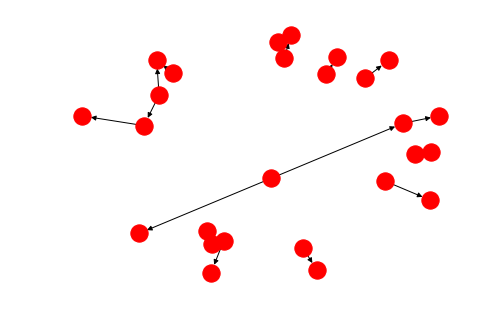

In [137]:
nx.draw(distance_graph)

In [382]:
nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(distance_graph)

nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
                             password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

Generating CX


'http://public.ndexbio.org/v2/network/e70d7bdd-ff83-11e9-bb65-0ac135e8bacf'